# Load packages

In [1]:
# Packages
import os
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from nervaluate import Evaluator
import itertools
from IPython.display import display
from utils import preprocess_rater, list_overlap, average_score, rater_avg_df

# Load data and preprocess

In [2]:
def prepare_NER(df_rater):
    """Function to prepare NER tags for a single rater for interrater calculations.

    Args:
        df_rater (pd.DataFrame): preprocessed dataframe of single rater

    Returns:
        pd.DataFrame: dataframe with preprocessed NER tags, one row per token, with NER tags
    """
    # Delete irrelevant columns
    df_clean = df_rater.drop(["meta", "_input_hash", "_task_hash", "_is_binary", "_view_id", "answer", "_timestamp"], axis=1)
    # Put each token on its own line
    exploded_tokens = df_clean.explode("tokens", ignore_index=True)
    # Normalise tokens column (expanding json format)
    normalised_tokens = pd.json_normalize(exploded_tokens["tokens"]).add_prefix("tokens_")
    # Add normalised columns to the data and delete old spans
    tokens = pd.concat([exploded_tokens, normalised_tokens], axis=1)

    # Put each rated NE on its own line
    exploded_spans = tokens.explode("spans", ignore_index=True)
    # Normalise span column
    normalised_spans = pd.json_normalize(exploded_spans["spans"]).add_prefix("spans_")
    # Normalise spans so that the info is in the dataframe
    spans = pd.concat([exploded_spans, normalised_spans], axis=1)

    # Only keep one row for each NE, i.e. only keep the rows where the token is within in the span of the NE 
    ne_tokens = spans[(spans.tokens_id >= spans.spans_token_start) & (spans.tokens_id <= spans.spans_token_end)]
    #print("Number of NEs for rater:", ne_tokens.shape)
    ne_tokens = ne_tokens.drop(["spans", "tokens"], axis=1)

    return pd.merge(tokens, ne_tokens, on=['rater_id', 'doc', 'tokens_text', 'tokens_start', 'tokens_end', 'tokens_id', 'tokens_ws'], how="outer") 

In [3]:
raterdf_list = []
NERdf_list = []

for id in range(1, 11): 
    raw_data = pd.read_json(f"../data/prodigy_exports/prodigy{id}_db_exports/NER_interannotator_annotator{id}.jsonl", lines=True)
    
    # List of preprocessed data
    preprocessed_df = preprocess_rater(raw_data, id)
    raterdf_list.append(preprocessed_df)
    
    # List of NER data
    NER_df = prepare_NER(preprocessed_df)
    NERdf_list.append(NER_df)

### After loading data, we now have the following format, in which:
- Each element is a dataframe
- raterdf_list has entire doc in each row, with a list of tokens in each
    - spans, have information on where token is located and any NER-tag
- NERdf_list has single tokens in each row
    - spans_label, has information on any potential token-tag

In [4]:
print(raterdf_list[0]["doc"][68])
print(raterdf_list[0]["spans"][68])
print(raterdf_list[0]["spans"][68][0]["label"])
raterdf_list[0].head(2)

i pådømmelsen har deltaget fem dommere: torben melchior, per sørensen, thomas rørdam,

[{'start': 27, 'end': 30, 'token_start': 4, 'token_end': 4, 'label': 'CARDINAL'}, {'start': 40, 'end': 55, 'token_start': 7, 'token_end': 8, 'label': 'PERSON'}, {'start': 57, 'end': 69, 'token_start': 10, 'token_end': 11, 'label': 'PERSON'}, {'start': 71, 'end': 84, 'token_start': 13, 'token_end': 14, 'label': 'PERSON'}]
CARDINAL


,rater_id,doc,meta,_input_hash,_task_hash,tokens,spans,_is_binary,_view_id,answer,_timestamp
0,1,"Grænselukning giver ingen mening, fordi Danmar...","{'start_id': '1238865417248165895', 'start_use...",894902064,-1699374015,"[{'text': 'Grænselukning', 'start': 0, 'end': ...","[{'start': 40, 'end': 47, 'token_start': 6, 't...",False,ner_manual,accept,1636479312
1,1,"Hvis du ikke stoler på mig, så lyt til ⁦@SSTbr...","{'start_id': '1238865417248165895', 'start_use...",-1423777743,-1958165638,"[{'text': 'Hvis', 'start': 0, 'end': 4, 'id': ...","[{'start': 39, 'end': 53, 'token_start': 10, '...",False,ner_manual,accept,1636479326


In [5]:
print(NERdf_list[0]["spans_label"][6])
print(NERdf_list[0]["spans"][6])

NERdf_list[0].head(2)

GPE
[{'start': 40, 'end': 47, 'token_start': 6, 'token_end': 6, 'label': 'GPE'}]


,rater_id,doc,tokens,spans,tokens_text,tokens_start,tokens_end,tokens_id,tokens_ws,spans_start,spans_end,spans_token_start,spans_token_end,spans_label
0,1,"Grænselukning giver ingen mening, fordi Danmar...","{'text': 'Grænselukning', 'start': 0, 'end': 1...","[{'start': 40, 'end': 47, 'token_start': 6, 't...",Grænselukning,0,13,0,True,NaN,NaN,NaN,NaN,NaN
1,1,"Grænselukning giver ingen mening, fordi Danmar...","{'text': 'giver', 'start': 14, 'end': 19, 'id'...","[{'start': 40, 'end': 47, 'token_start': 6, 't...",giver,14,19,1,True,NaN,NaN,NaN,NaN,NaN


# Explore interrater reliability

### How do the documents overlap between raters?

In [6]:
# Get rater ids
raters = [df.rater_id[1] for df in raterdf_list]
print(raters)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [7]:
# Check document overlap of annotators
overlap_list = []
for i in range(len(raters)):
    raterA_df = raterdf_list[i]
    overlap_list.append([len(list_overlap(raterA_df.doc, raterB_df.doc)) for raterB_df in raterdf_list])

# Create dataframe for text overlap
print("OVERLAP OF UNIQUE DOCUMENTS FOR RATERS ON NER TAGS")
overlap_df = pd.DataFrame(data=np.array(overlap_list), index=raters, columns=pd.Index(raters, name="Rater"))
overlap_df


OVERLAP OF UNIQUE DOCUMENTS FOR RATERS ON NER TAGS


Rater,1,2,3,4,5,6,7,8,9,10
1,411,366,364,367,358,368,353,306,351,295
2,366,390,368,374,359,375,352,306,350,300
3,364,368,429,372,360,370,354,308,352,296
4,367,374,372,436,360,376,354,307,352,301
5,358,359,360,360,408,361,351,303,349,287
6,368,375,370,376,361,421,354,308,352,303
7,353,352,354,354,351,354,411,300,347,284
8,306,306,308,307,303,308,300,371,344,287
9,351,350,352,352,349,352,347,344,414,281
10,295,300,296,301,287,303,284,287,281,351


In [8]:
overlap_df.to_csv("../output/DANSK_initial_interrater/doc_overlap.csv")

### How much do the raters agree with one another on the NER tagging (including cases in which neither tagged a given word)

In [9]:
kappa_list = []
token_overlap_list = []

# For each rater
for raterA in range(len(raters)):
    
    kappa_rater = []
    token_overlap_rater = []

    # Create pair with another rater
    for raterB in range(len(raters)):

        # Merge dataframes on tokens
        df_pair = pd.merge(NERdf_list[raterA], NERdf_list[raterB], on=["doc", "tokens_text", "tokens_start", "tokens_end"], suffixes=["_raterA", "_raterB"])
        df_pair[["spans_label_raterA", "spans_label_raterB"]] = df_pair[["spans_label_raterA", "spans_label_raterB"]].fillna("")
        
        # Get the number of overlapping tokens
        token_overlap = len(df_pair)
        token_overlap_rater.append(token_overlap)
        # Get kappa
        kappa = cohen_kappa_score(df_pair.spans_label_raterA, df_pair.spans_label_raterB)
        kappa_rater.append(kappa)

    kappa_list.append(kappa_rater)
    token_overlap_list.append(token_overlap_rater)

kappa_array = np.array(kappa_list)
token_overlap_array = np.array(token_overlap_list)

In [10]:
kappa_df = pd.DataFrame(data=kappa_array, index=raters, columns=pd.Index(raters, name="Rater"))

# Print average kappa across pairs
print("AVERAGE KAPPA ACROSS PAIRS")
average_score(kappa_df)

# Print df with pairwise scores
print("\nPAIRWISE KAPPAS")
kappa_df_avg = rater_avg_df(kappa_df).round(2)
kappa_df_avg


AVERAGE KAPPA ACROSS PAIRS
Mean (SD) Score: 0.7331528117693494 (0.06717700598590087)

PAIRWISE KAPPAS


Rater,1,2,3,4,5,6,7,8,9,10,rater_avg
1,1.00,0.79,0.70,0.90,0.82,0.88,0.66,0.72,0.72,0.75,0.77
2,0.79,1.00,0.69,0.77,0.76,0.77,0.58,0.69,0.70,0.77,0.72
3,0.70,0.69,1.00,0.69,0.66,0.66,0.71,0.76,0.72,0.82,0.71
4,0.90,0.77,0.69,1.00,0.80,0.85,0.65,0.72,0.77,0.74,0.76
5,0.82,0.76,0.66,0.80,1.00,0.80,0.62,0.70,0.67,0.78,0.73
6,0.88,0.77,0.66,0.85,0.80,1.00,0.62,0.69,0.69,0.74,0.74
7,0.66,0.58,0.71,0.65,0.62,0.62,1.00,0.72,0.76,0.81,0.68
8,0.72,0.69,0.76,0.72,0.70,0.69,0.72,1.00,0.74,0.73,0.72
9,0.72,0.70,0.72,0.77,0.67,0.69,0.76,0.74,1.00,0.72,0.72
10,0.75,0.77,0.82,0.74,0.78,0.74,0.81,0.73,0.72,1.00,0.76


In [11]:
kappa_df_avg.to_csv("../output/DANSK_initial_interrater/kappa_also_non_annotated.csv")

### How much do the raters agree with one another on the NER-tagging (excluding cases in which neither tagged a given word as a NE )

In [12]:
print("PAIRWISE TOKEN OVERLAP (USED FOR CALCULATION OF KAPPAS)")
token_overlap_df = pd.DataFrame(data=token_overlap_array, index=raters, columns=pd.Index(raters, name="Rater"))
token_overlap_df

#token_overlap_df.to_csv("../../output/NER/NER_token_overlap_all.csv")

PAIRWISE TOKEN OVERLAP (USED FOR CALCULATION OF KAPPAS)


Rater,1,2,3,4,5,6,7,8,9,10
1,3761,3302,3346,3352,3319,3360,3286,3166,3280,3122
2,3302,3470,3302,3315,3268,3323,3231,3113,3225,3080
3,3346,3302,3733,3363,3322,3360,3289,3171,3283,3119
4,3352,3315,3363,3771,3318,3373,3289,3163,3283,3130
5,3319,3268,3322,3318,3697,3326,3282,3151,3274,3085
6,3360,3323,3360,3373,3326,3742,3289,3171,3283,3141
7,3286,3231,3289,3289,3282,3289,3671,3125,3262,3059
8,3166,3113,3171,3163,3151,3171,3125,3577,3374,3081
9,3280,3225,3283,3283,3274,3283,3262,3374,3684,3048
10,3122,3080,3119,3130,3085,3141,3059,3081,3048,3482


In [13]:
kappa_list = []
token_overlap_list = []

# For each rater
for raterA in range(0, len(raters)):
    
    kappa_rater = []
    token_overlap_rater = []

    # Create pair with other raters
    for raterB in range(0, len(raters)):

        # Merge data of pairs on tokens
        df_pair = pd.merge(NERdf_list[raterA], NERdf_list[raterB], on=["doc", "tokens_text", "tokens_start", "tokens_end"], suffixes=["_raterA", "_raterB"])
        # Keep only if annotated by at least one rater
        df_annotated = df_pair.dropna(subset=["spans_label_raterA", "spans_label_raterB"], how="all").reset_index().fillna("")

        # Get number of overlapping tokens
        token_overlap = len(df_annotated)
        token_overlap_rater.append(token_overlap)
        # Get kappa
        kappa = cohen_kappa_score(df_annotated.spans_label_raterA, df_annotated.spans_label_raterB)
        kappa_rater.append(kappa)

    # Append to list
    kappa_list.append(kappa_rater)
    token_overlap_list.append(token_overlap_rater)

kappa_array = np.array(kappa_list)
token_overlap_array = np.array(token_overlap_list)

In [14]:
kappa_df = pd.DataFrame(data=kappa_array, index=raters, columns=pd.Index(raters, name="Rater"))

print("AVERAGE KAPPA ACROSS PAIRS")
average_score(kappa_df)
print("\nPAIRWISE KAPPAS")
kappa_df_avg = rater_avg_df(kappa_df).round(2)
kappa_df_avg

AVERAGE KAPPA ACROSS PAIRS
Mean (SD) Score: 0.5380952087681506 (0.09317426754711709)

PAIRWISE KAPPAS


Rater,1,2,3,4,5,6,7,8,9,10,rater_avg
1,1.00,0.62,0.51,0.80,0.66,0.77,0.46,0.53,0.53,0.54,0.60
2,0.62,1.00,0.48,0.57,0.56,0.59,0.33,0.47,0.48,0.57,0.52
3,0.51,0.48,1.00,0.48,0.44,0.44,0.49,0.57,0.51,0.66,0.51
4,0.80,0.57,0.48,1.00,0.63,0.71,0.44,0.51,0.60,0.51,0.58
5,0.66,0.56,0.44,0.63,1.00,0.62,0.40,0.49,0.46,0.61,0.54
6,0.77,0.59,0.44,0.71,0.62,1.00,0.41,0.47,0.49,0.53,0.56
7,0.46,0.33,0.49,0.44,0.40,0.41,1.00,0.50,0.57,0.64,0.47
8,0.53,0.47,0.57,0.51,0.49,0.47,0.50,1.00,0.55,0.52,0.51
9,0.53,0.48,0.51,0.60,0.46,0.49,0.57,0.55,1.00,0.50,0.52
10,0.54,0.57,0.66,0.51,0.61,0.53,0.64,0.52,0.50,1.00,0.56


In [15]:
kappa_df_avg.to_csv("../output/DANSK_initial_interrater/kappa_annotated.csv")

### Between raters, how similar did they tag overall?

- For information on the calculations, see: https://pypi.org/project/nervaluate/


In [16]:
f1_list = []
f1_tags_list = []

# For each rater
for raterA in range(0, len(raters)):
    
    f1_rater = []
    f1_tags_rater = []

    # Pair with other rater
    for raterB in range(0, len(raters)):

        # Prepare data
        raterA_data = NERdf_list[raterA].copy().drop_duplicates(subset="doc")
        raterB_data = NERdf_list[raterB].copy().drop_duplicates(subset="doc")
        pair = pd.merge(raterA_data, raterB_data, on="doc", suffixes=["_raterA", "_raterB"], how="inner")

        # Prepare labels
        raterA_labels = pair.spans_raterA.tolist()
        raterB_labels = pair.spans_raterB.tolist()
        all_labels = list(itertools.chain.from_iterable(raterA_labels + raterB_labels))
        label_set = list(set([d["label"] for d in all_labels if "label" in d]))

        # Get F1 scores
        evaluator = Evaluator(raterA_labels, raterB_labels, tags=label_set)
        results, results_by_tag = evaluator.evaluate()

        # Append to list
        f1_rater.append(results)
        f1_tags_rater.append(results_by_tag)

    f1_list.append(f1_rater)
    f1_tags_list.append(f1_tags_rater)

In [17]:
# Extract separate f1 scores from results and store in arrays in dict
f1_dict = {
    "STRICT": np.array([[f1B["strict"]["f1"] for f1B in f1A] for f1A in f1_list]),
    "EXACT": np.array([[f1B["exact"]["f1"] for f1B in f1A] for f1A in f1_list]),
    "PARTIAL": np.array([[f1B["partial"]["f1"] for f1B in f1A] for f1A in f1_list]),
    "ENT_TYPE": np.array([[f1B["ent_type"]["f1"] for f1B in f1A] for f1A in f1_list])
}

# Print results for each type of F1 Score
for type in f1_dict.keys():

    type_df = pd.DataFrame(data=f1_dict[type], index=raters, columns=pd.Index(raters, name="Rater"))

    print(f"AVERAGE F1 SCORE ON {type} MATCH")
    average_score(type_df)

    print(f"\nPAIRWISE F1 SCORE ON {type} MATCH")
    type_df_avg = rater_avg_df(type_df).round(2)
    display(type_df_avg)

    #type_df_avg.to_csv(f"../../output/NER/NER_F1_{type}.csv")

AVERAGE F1 SCORE ON STRICT MATCH
Mean (SD) Score: 0.5487258150128709 (0.14333662679186962)

PAIRWISE F1 SCORE ON STRICT MATCH


Rater,1,2,3,4,5,6,7,8,9,10,rater_avg
1,1.00,0.53,0.70,0.82,0.71,0.78,0.61,0.63,0.67,0.33,0.64
2,0.53,1.00,0.47,0.50,0.39,0.50,0.33,0.39,0.40,0.67,0.46
3,0.70,0.47,1.00,0.64,0.55,0.63,0.62,0.65,0.64,0.41,0.59
4,0.82,0.50,0.64,1.00,0.67,0.70,0.55,0.65,0.74,0.29,0.62
5,0.71,0.39,0.55,0.67,1.00,0.66,0.61,0.56,0.58,0.36,0.57
6,0.78,0.50,0.63,0.70,0.66,1.00,0.52,0.56,0.56,0.38,0.59
7,0.61,0.33,0.62,0.55,0.61,0.52,1.00,0.54,0.61,0.42,0.53
8,0.63,0.39,0.65,0.65,0.56,0.56,0.54,1.00,0.65,0.27,0.54
9,0.67,0.40,0.64,0.74,0.58,0.56,0.61,0.65,1.00,0.23,0.57
10,0.33,0.67,0.41,0.29,0.36,0.38,0.42,0.27,0.23,1.00,0.37


AVERAGE F1 SCORE ON EXACT MATCH
Mean (SD) Score: 0.6621004711886572 (0.14132640305901656)

PAIRWISE F1 SCORE ON EXACT MATCH


Rater,1,2,3,4,5,6,7,8,9,10,rater_avg
1,1.00,0.54,0.74,0.91,0.85,0.82,0.74,0.74,0.77,0.44,0.73
2,0.54,1.00,0.53,0.57,0.50,0.55,0.46,0.47,0.49,0.82,0.55
3,0.74,0.53,1.00,0.74,0.72,0.68,0.76,0.79,0.76,0.52,0.69
4,0.91,0.57,0.74,1.00,0.82,0.79,0.77,0.76,0.80,0.48,0.74
5,0.85,0.50,0.72,0.82,1.00,0.80,0.70,0.74,0.70,0.41,0.69
6,0.82,0.55,0.68,0.79,0.80,1.00,0.63,0.67,0.65,0.56,0.68
7,0.74,0.46,0.76,0.77,0.70,0.63,1.00,0.73,0.81,0.47,0.68
8,0.74,0.47,0.79,0.76,0.74,0.67,0.73,1.00,0.72,0.45,0.67
9,0.77,0.49,0.76,0.80,0.70,0.65,0.81,0.72,1.00,0.41,0.68
10,0.44,0.82,0.52,0.48,0.41,0.56,0.47,0.45,0.41,1.00,0.51


AVERAGE F1 SCORE ON PARTIAL MATCH
Mean (SD) Score: 0.7456373130657878 (0.10246248935379038)

PAIRWISE F1 SCORE ON PARTIAL MATCH


Rater,1,2,3,4,5,6,7,8,9,10,rater_avg
1,1.00,0.68,0.79,0.93,0.89,0.88,0.77,0.81,0.80,0.58,0.79
2,0.68,1.00,0.64,0.69,0.64,0.68,0.57,0.61,0.62,0.84,0.66
3,0.79,0.64,1.00,0.79,0.78,0.76,0.81,0.85,0.81,0.66,0.76
4,0.93,0.69,0.79,1.00,0.87,0.87,0.80,0.83,0.83,0.61,0.80
5,0.89,0.64,0.78,0.87,1.00,0.87,0.75,0.82,0.77,0.58,0.78
6,0.88,0.68,0.76,0.87,0.87,1.00,0.71,0.77,0.74,0.66,0.77
7,0.77,0.57,0.81,0.80,0.75,0.71,1.00,0.81,0.84,0.60,0.74
8,0.81,0.61,0.85,0.83,0.82,0.77,0.81,1.00,0.80,0.60,0.77
9,0.80,0.62,0.81,0.83,0.77,0.74,0.84,0.80,1.00,0.55,0.75
10,0.58,0.84,0.66,0.61,0.58,0.66,0.60,0.60,0.55,1.00,0.63


AVERAGE F1 SCORE ON ENT_TYPE MATCH
Mean (SD) Score: 0.6620286038593773 (0.08326591957293727)

PAIRWISE F1 SCORE ON ENT_TYPE MATCH


Rater,1,2,3,4,5,6,7,8,9,10,rater_avg
1,1.00,0.72,0.75,0.85,0.75,0.84,0.63,0.72,0.70,0.58,0.73
2,0.72,1.00,0.63,0.66,0.62,0.68,0.47,0.60,0.58,0.71,0.63
3,0.75,0.63,1.00,0.70,0.62,0.67,0.67,0.73,0.69,0.64,0.68
4,0.85,0.66,0.70,1.00,0.75,0.78,0.58,0.73,0.77,0.51,0.70
5,0.75,0.62,0.62,0.75,1.00,0.71,0.64,0.68,0.66,0.64,0.67
6,0.84,0.68,0.67,0.78,0.71,1.00,0.59,0.67,0.64,0.55,0.68
7,0.63,0.47,0.67,0.58,0.64,0.59,1.00,0.62,0.64,0.66,0.61
8,0.72,0.60,0.73,0.73,0.68,0.67,0.62,1.00,0.74,0.53,0.67
9,0.70,0.58,0.69,0.77,0.66,0.64,0.64,0.74,1.00,0.49,0.66
10,0.58,0.71,0.64,0.51,0.64,0.55,0.66,0.53,0.49,1.00,0.59


### Between raters, how similar did they tag for each of the individual NER groups?

- For information on the calculations, see: https://pypi.org/project/nervaluate/


In [18]:
# Get unique tags across raters
tags = []
for rater in NERdf_list:
    tags = tags + rater["spans_label"].to_list()
unique_tags = list(set(tags))
unique_tags.append("PERCENT")

In [19]:
# Get number of annotations by tag by rater
rater_tag_counts = {}

# For each rater count the number of tags
for rater in range(len(raters)):
    tag_counts = NERdf_list[rater].value_counts("spans_label")
    rater_tag_counts[rater] = tag_counts    

print("TOTAL NUMBER OF ANNOTATED NER TAGS BY RATER")
NER_tag_counts = pd.DataFrame(rater_tag_counts).fillna(0).astype(int)
# Append row to the DataFrame

PERCENT_ROW = pd.DataFrame({0:[0], 1:[0], 2:[0], 3:[0], 4:[0], 5:[0], 6:[0], 7:[0], 8:[0], 9:[0]})
PERCENT_ROW.index = ["PERCENT"]
NER_tag_counts = pd.concat([NER_tag_counts, PERCENT_ROW]).sort_index()
NER_tag_counts.columns = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
display(NER_tag_counts)

TOTAL NUMBER OF ANNOTATED NER TAGS BY RATER


,1,2,3,4,5,6,7,8,9,10
CARDINAL,40,64,61,18,60,65,47,21,13,61
DATE,91,63,52,48,79,76,37,77,41,60
EVENT,11,10,16,15,11,12,13,15,15,14
FACILITY,0,10,0,0,21,10,21,20,19,10
GPE,24,16,22,20,20,24,26,24,26,20
LANGUAGE,0,0,0,2,0,0,0,0,0,0
LAW,59,0,14,58,6,47,50,25,49,5
LOCATION,13,3,21,11,3,1,4,8,7,2
MONEY,16,2,16,14,16,16,16,16,16,16
NORP,41,37,39,40,6,37,2,53,31,11


In [20]:
NER_tag_counts.to_csv("../output/DANSK_initial_interrater/tag_counts.csv")

In [21]:
def extract_tag_f1(f1_type, tag, results_tags_list):
    """Function to extract type of F1 score for specific tag.

    Args:
        f1_type (str): "strict", "exact", "type" or "partial"
        tag (str): NER tag
        results_tags_list (list): list of all results

    Returns:
        list: List of list of scores for each rater
    """
    scores = []
    # For each rater
    for raterA in results_tags_list:
        raterA_scores = []
        # And each pair rater 
        for raterB in raterA:
            # Get the F1 score
            if tag in raterB.keys():
                tag_scores = raterB[str(tag)][f1_type]["f1"]
            else:
                tag_scores = np.nan
                # Append to rater scores
            raterA_scores.append(tag_scores)
        # Append to all scores
        scores.append(raterA_scores)
        
    return scores

In [22]:
# Get strict F1 scores by tag
tag_f1_dict = {}
tag_avg_dict = {}

# For each tag get the strict f1 score from the results
for tag in unique_tags:
    tag_f1 = extract_tag_f1("strict", tag, f1_tags_list)
    # Pairwise f1 scores for tag
    tag_f1_dict[tag] = pd.DataFrame(tag_f1).round(2)
    # Averaged f1 scores for tag
    tag_avg_dict[tag] = average_score(pd.DataFrame(tag_f1), print_score=False)

print("AVERAGE STRICT F1-SCORE BY TAG")
tag_f1_avg = pd.DataFrame(tag_avg_dict, index=["f1_mean", "f1_sd"]).T.round(2).sort_index()
display(tag_f1_avg)

AVERAGE STRICT F1-SCORE BY TAG


,f1_mean,f1_sd
CARDINAL,0.47,0.23
DATE,0.55,0.21
EVENT,0.50,0.34
FACILITY,0.22,0.38
GPE,0.91,0.05
LANGUAGE,0.00,0.00
LAW,0.23,0.32
LOCATION,0.22,0.24
MONEY,0.62,0.49
NORP,0.50,0.39


In [23]:
tag_f1_avg.to_csv("../output/DANSK_initial_interrater/f1_tag_strict.csv")

In [34]:
unique_tags

['NORP',
 'LANGUAGE',
 'DATE',
 'WORK OF ART',
 nan,
 'MONEY',
 'CARDINAL',
 'ORGANIZATION',
 'GPE',
 'LAW',
 'TIME',
 'LOCATION',
 'EVENT',
 'QUANTITY',
 'FACILITY',
 'PRODUCT',
 'PERSON',
 'ORDINAL',
 'PERCENT']

AVERAGE STRICT F1-SCORE BY TAG AND RATER


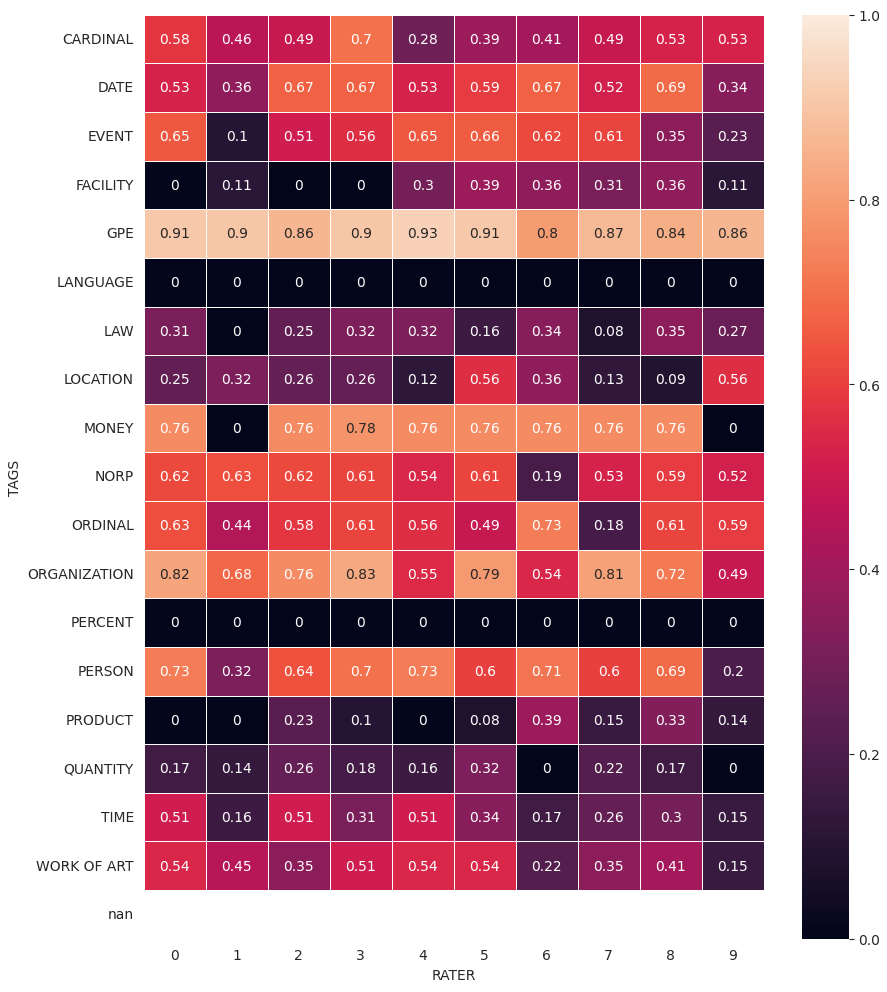

In [44]:
unique_tags = [unique_tag for unique_tag in unique_tags if unique_tag !="PERCENT"]
# Get F1 Scores by tag and rater
rater_avgs = []
# For all tags (exc)
for tag in unique_tags:
    # Extract f1 scores for tag
    tag_f1 = tag_f1_dict[tag]
    # Get the rater averages
    rater_avg = rater_avg_df(tag_f1)["rater_avg"].tolist()
    rater_avgs.append(rater_avg) 

# Store in dataframe and sort
df = pd.DataFrame(rater_avgs, index = unique_tags)
df = df.sort_index()
PERCENT_ROW = pd.DataFrame({0:[0], 1:[0], 2:[0], 3:[0], 4:[0], 5:[0], 6:[0], 7:[0], 8:[0], 9:[0]})
PERCENT_ROW.index = ["PERCENT"]
df = pd.concat([df, PERCENT_ROW]).sort_index()

# Create matrix
print("AVERAGE STRICT F1-SCORE BY TAG AND RATER")
plt.figure(figsize=(10,12))
with sns.axes_style("white"):
    s = sns.heatmap(np.array(df), xticklabels=df.columns, yticklabels=df.index, annot=True, linewidths=0.5, vmax=1.0, cbar=True)
    s.set(ylabel='TAGS', xlabel='RATER');


In [45]:
df.to_csv("../output/DANSK_initial_interrater/avg_f1_strict.csv")

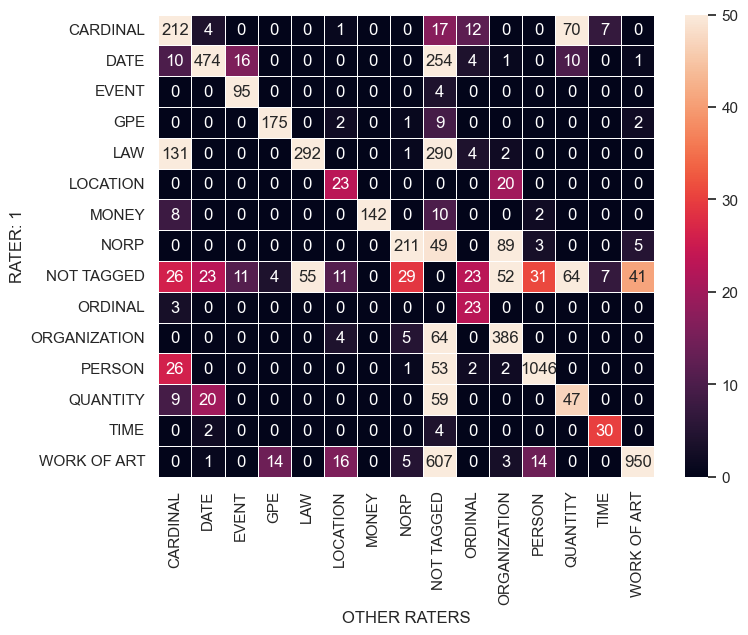

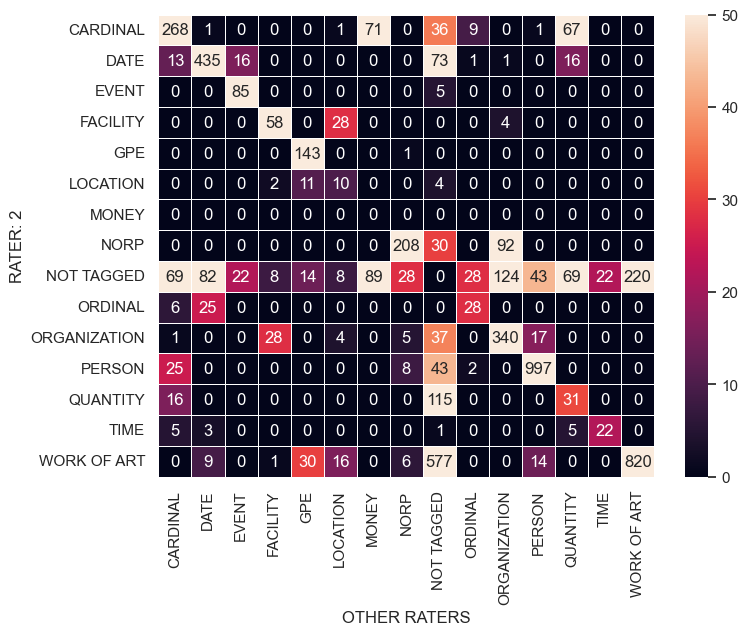

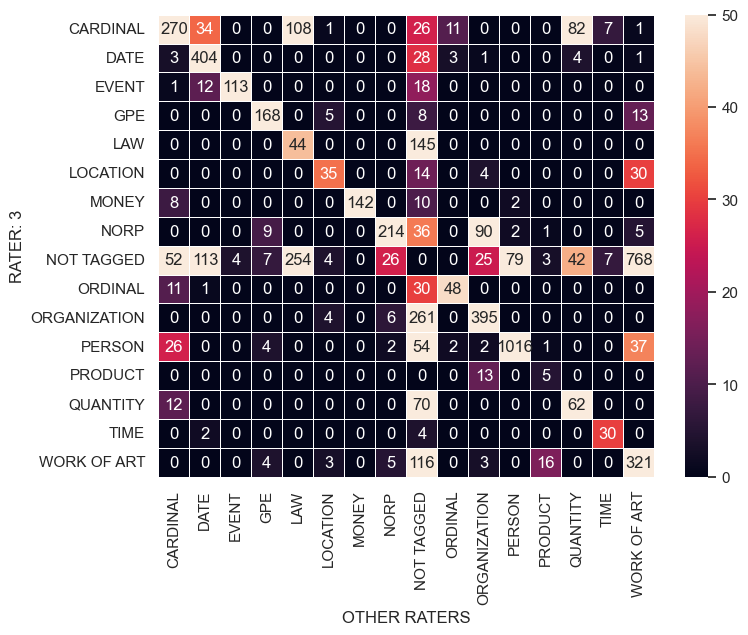

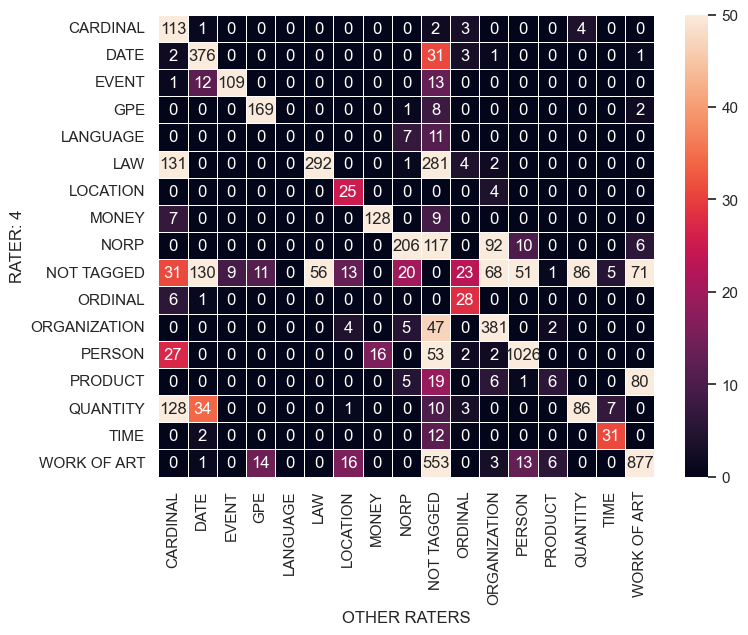

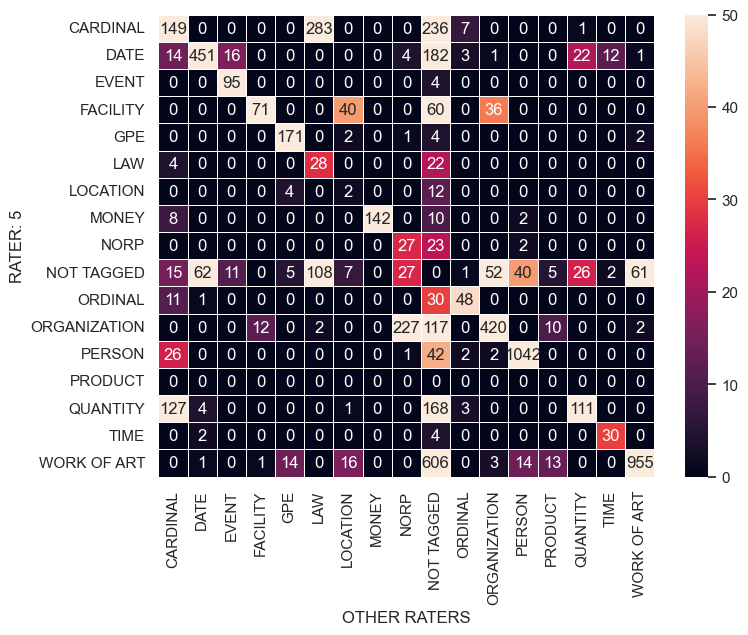

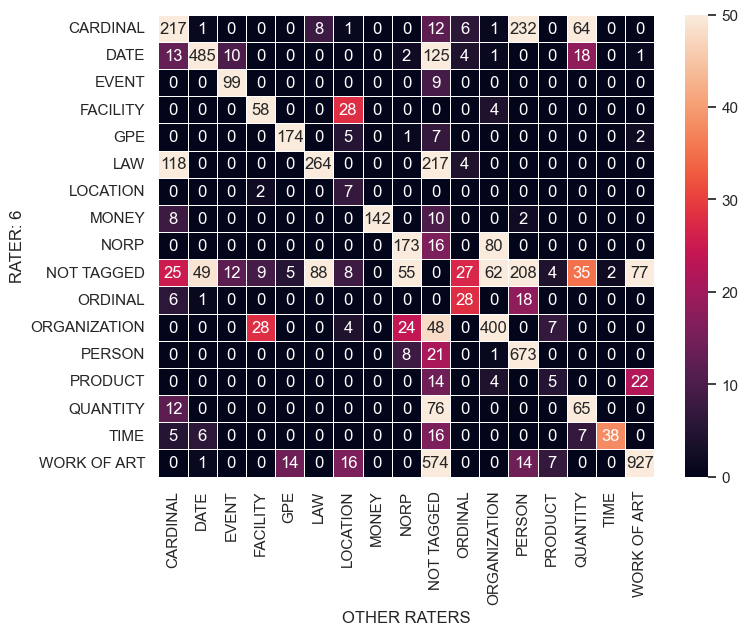

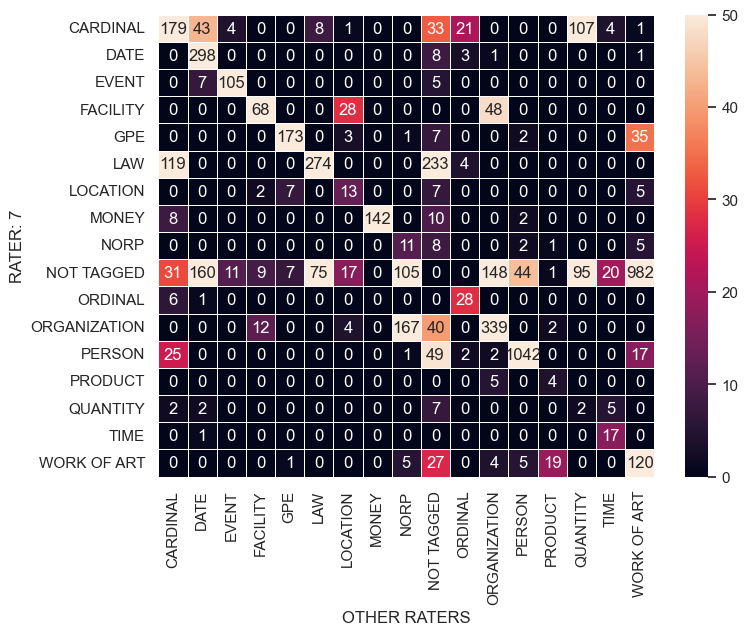

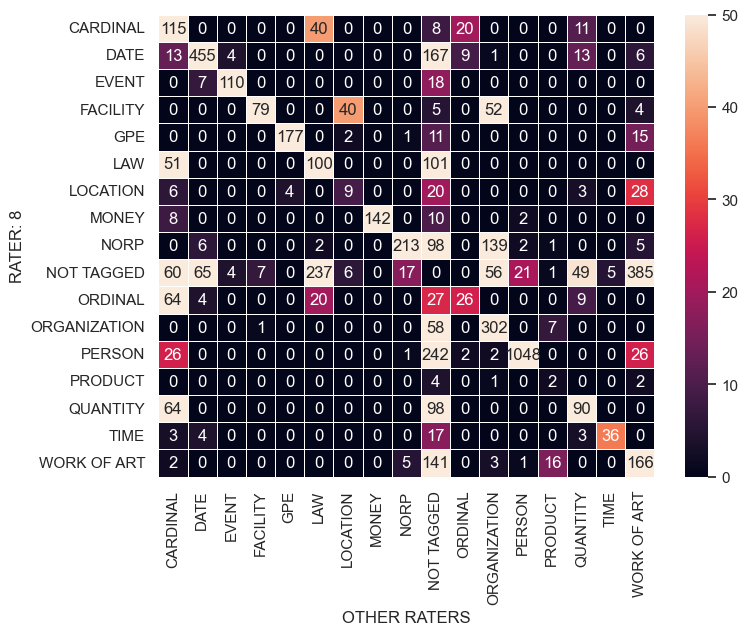

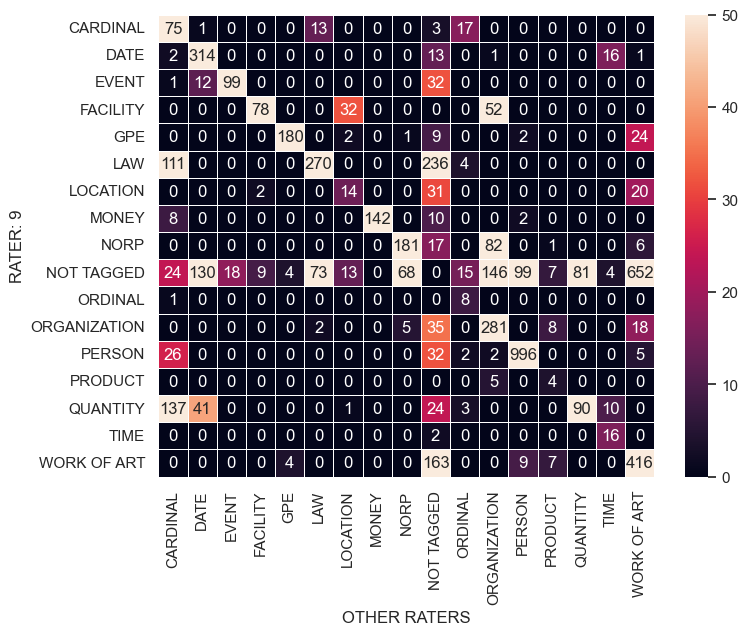

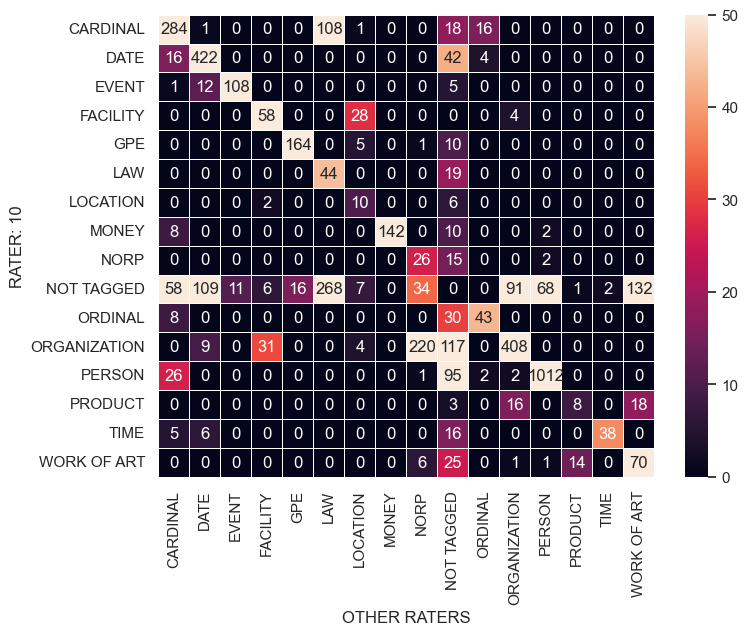

In [46]:
# Make confusion matrix for each rater vs all other raters
sns.set_theme(style='white')
for raterA in range(0, len(raters)):

    # Get the data for raterA
    raterA_data = NERdf_list[raterA].copy()
    # Get the labels for raterA
    labels = sorted(list(set(raterA_data.fillna("NOT TAGGED", inplace=False)["spans_label"].tolist())))

    # List of confusion matrices
    cms = []

    # Get list of other raters, without raterA
    other_raters = list(range(0, len(raters)))
    other_raters.remove(raterA)
    
    # Prepare data for raterB and pair
    for raterB in other_raters:
        raterB_data = NERdf_list[raterB].copy()

        # Merge data
        pair = pd.merge(raterA_data, raterB_data, on=["doc", "tokens_text"], suffixes=["_raterA", "_raterB"])
        # Drop rows where both have NAs
        pair = pair.dropna(subset=["spans_label_raterA", "spans_label_raterB"], how="all")
        # Fill np.nan with NA
        pair["spans_label_raterA"] = pair["spans_label_raterA"].fillna("NOT TAGGED")
        pair["spans_label_raterB"] = pair["spans_label_raterB"].fillna("NOT TAGGED")

        # Create confusion matrix
        # raterA = row(y), raterB = columns(x)
        cm = confusion_matrix(y_true=pair.spans_label_raterA, y_pred=pair.spans_label_raterB, labels=labels)
        cms.append(cm)

    # Make the sum across all cms
    sum_cms = sum(cms)

    # Make plot
    plt.figure(figsize=(8,6))
    with sns.axes_style("white"):
        s = sns.heatmap(sum_cms, yticklabels=labels, xticklabels=labels, annot=True, linewidths=0.5, vmax=50, cbar=True, fmt="g")
        s.set(ylabel=f'RATER: {raterA+1}', xlabel='OTHER RATERS')
    
